# NLP And Random Forest Modeling

In this notebook NLP and EDA will be performed on subreddits dataset.

In [73]:
import requests
import math
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


In [74]:
df = pd.read_csv('data/subreddits.csv')

### Converting python/R to binary labels:

In [75]:
# Create label column for Python and Rlanguage subreddits
df['subreddit'] = df['subreddit'].map({'breakingbad': 0, 'betterCallSaul': 1})

df.drop(columns = 'Unnamed: 0', inplace= True)
df.head()

,subreddit,selftext,title
0,1,"All you people say ""oh boohoo Jimmy, boohoohoo...",Stop denying it. Chuck was right
1,1,We all know that the excavation happened in th...,Where exactly is the excavation project
2,1,Mine is probably Dedicado a Max. It's not horr...,Least favorite episode?
3,1,NaN,Better SUCK Chuck (Official Music Video) pls c...
4,1,NaN,Salamanca Brothers


In [76]:
# Rename Column name
df = df.rename(columns={'selftext': 'post'})
df.isna().sum()

subreddit       0
post         2503
title           0
dtype: int64

In [77]:
# Function to count words in each post:
def word_count(post):
    word_count = 0
    is_in_word = False
    for char in post:
        if char in ' \t\n.!,:;/?\\()"':
            is_in_word = False
        else:
            if not is_in_word:
                word_count += 1
                is_in_word = True

    return (word_count)

In [78]:
# Adding two columns showing number of words in each text
df['title_length'] = [word_count(comment) for comment in df['title']]
df.shape

(4993, 4)

In [79]:
df.head()

,subreddit,post,title,title_length
0,1,"All you people say ""oh boohoo Jimmy, boohoohoo...",Stop denying it. Chuck was right,6
1,1,We all know that the excavation happened in th...,Where exactly is the excavation project,6
2,1,Mine is probably Dedicado a Max. It's not horr...,Least favorite episode?,3
3,1,NaN,Better SUCK Chuck (Official Music Video) pls c...,12
4,1,NaN,Salamanca Brothers,2


# NLP

In [80]:
X = df['title']
y = df['subreddit']

In [81]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

# Preprocessing

#### Countvectorizer

In [82]:
# Instantiate with stop words and n-grams:
cvec = CountVectorizer(#tokenizer = '\w+', 
                       stop_words = 'english', 
                       ngram_range = (1,2), 
                       max_features=3000, 
                       min_df=2, 
                       max_df=.98)

In [83]:
cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

In [84]:
X_train.shape

(3744, 3000)

In [85]:
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())

/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


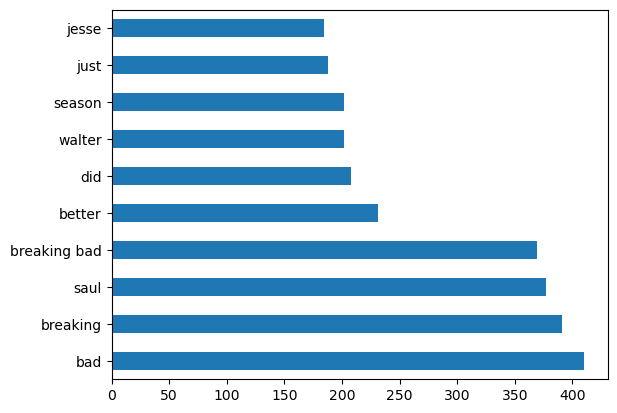

In [86]:
X_train_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

#### Baseline Accuracy

In [87]:
y_test.value_counts(normalize = True)

0    0.5004
1    0.4996
Name: subreddit, dtype: float64

In [88]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [89]:
#gb = GradientBoostingClassifier()

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])


In [90]:
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'rf': RandomForestClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_est

In [91]:
pipe_params = {
    'cvec__max_features': [1500, 2000, 2500, 3000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [10, 100],
    'rf__max_depth': [None, 1, 2, 3]
}

In [92]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv = 5,
                n_jobs= 8) 

In [93]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=8,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1500, 2000, 2500, 3000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'rf__max_depth': [None, 1, 2, 3],
                         'rf__n_estimators': [10, 100]})

In [94]:
# Best Params
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'rf__max_depth': None,
 'rf__n_estimators': 100}

In [95]:
# Score model on training set.
gs.score(X_train, y_train)

0.9780982905982906

In [96]:
# Score model on testing set.
gs.score(X_test, y_test)

0.734187349879904

In [97]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


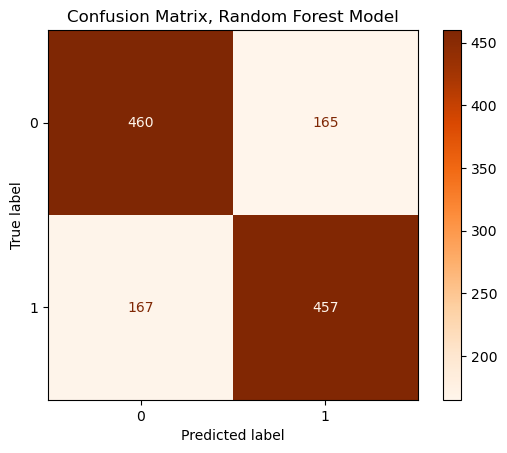

In [98]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Oranges', values_format='d')
plt.title('Confusion Matrix, Random Forest Model');
plt.savefig('image/rfconfusionm.png')

In [99]:
# Calculate the specificity
spec = tn / (tn + fp)

print(f'Specificity: {spec}')

Specificity: 0.736


In [100]:
# Calculate the sensitivity
sens = tp / (fn +tp)

print(f'Sensitivity: {sens}')

Sensitivity: 0.7323717948717948


In [101]:
accuracy_score(y_test, preds)

0.734187349879904

## TfidfVectorizer

In [48]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)
tvec = TfidfVectorizer()
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = 'english', 
                       ngram_range = (1,2), max_features=3000, 
                      min_df=2, max_df=.98)),
    ('rf', RandomForestClassifier())
])
pipe_tvec.get_params()

/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'memory': None,
 'steps': [('tvec',
   TfidfVectorizer(max_df=0.98, max_features=3000, min_df=2, ngram_range=(1, 2),
                   stop_words='english')),
  ('rf', RandomForestClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(max_df=0.98, max_features=3000, min_df=2, ngram_range=(1, 2),
                 stop_words='english'),
 'rf': RandomForestClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 0.98,
 'tvec__max_features': 3000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': 'english',
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_

In [51]:
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [10, 100],
    'rf__max_depth': [None, 1, 2, 3]
}

gs_tvec = GridSearchCV(pipe_tvec,
                      param_grid = pipe_tvec_params,
                      cv = 5,
                      n_jobs = 8)
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(max_df=0.98,
                                                        max_features=3000,
                                                        min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=8,
             param_grid={'rf__max_depth': [None, 1, 2, 3],
                         'rf__n_estimators': [10, 100],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [52]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.9647435897435898

In [53]:
gs_tvec.score(X_test, y_test)

0.7566052842273819

In [54]:
# Best params?
gs_tvec.best_params_

{'rf__max_depth': None,
 'rf__n_estimators': 100,
 'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [55]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity

spec = tn / (tn + fp)

print(f'Specificity: {spec}')

Specificity: 0.7776


/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


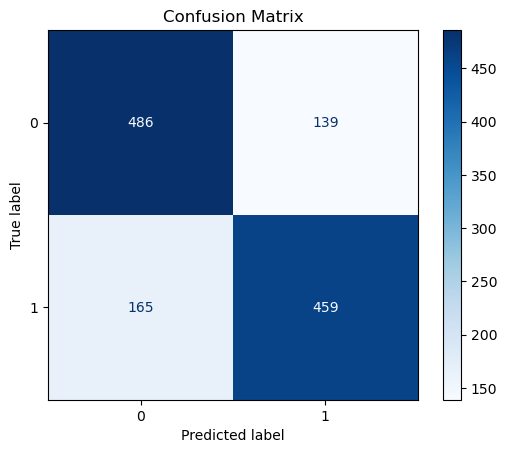

In [61]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap = 'Blues')
plt.title('Confusion Matrix');

## Test Accuracy:

In [59]:
accuracy_score(y_test, preds)

0.7269815852682145